In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import json
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 커뮤니티 게시글 데이터 로드

from communav.utils import db

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        labels.category_ids
    FROM everytime_articles articles
    JOIN everytime_article_labels labels ON articles.id = labels.article_id
''')
articles = cursor.fetchall()

cursor.close()
db.close_connection()

Connected to DB successfully.


In [4]:
# 가져온 데이터의 일부를 출력

for article in articles[:20]:
    print(article)

{'id': '100245988', 'title': '장학금 관련해서..', 'text': '성적장학금 + 한울장학금 가능한지 궁금합니다..', 'category_ids': '[1, 3]'}
{'id': '100634300', 'title': '배고파 집에가서', 'text': '진짬뽕에 밥 말아먹어야지 히힣', 'category_ids': '[]'}
{'id': '100656956', 'title': '부산 + 용인까지 의심 환자 발생', 'text': '평택시는 난리남.\n부산에서도..\n근데 이상한건 용인인데.\n그 분은 중국 갔다온사람 아니라던데?\n뭐냐 진짜..', 'category_ids': '[]'}
{'id': '100682214', 'title': '신종 코로나바이러스(2019-nCoV) 감염증 대처 방법', 'text': "원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.\n \n==========================================\n최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다. \n여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다. \n \n저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.\n \n개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 

In [5]:
# 이진 분류 문제를 위한 데이터 전처리

preprocessed_articles = []

for article in articles:
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ').strip()
    label = 1 if 5 in json.loads(article['category_ids']) else 0

    preprocessed_articles.append({
        'content': content,
        'label': label
    })

In [6]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다..', 'label': 0}
{'content': '배고파 집에가서 진짬뽕에 밥 말아먹어야지 히힣', 'label': 0}
{'content': '부산 + 용인까지 의심 환자 발생 평택시는 난리남. 부산에서도.. 근데 이상한건 용인인데. 그 분은 중국 갔다온사람 아니라던데? 뭐냐 진짜..', 'label': 0}
{'content': "신종 코로나바이러스(2019-nCoV) 감염증 대처 방법 원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.   ========================================== 최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다.  여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다.    저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.   개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 분들께서는 대부분 현장에서 나가 계셔서 저처럼 자리에 앉아 있으실 수 없을듯 합니다.     1. 신종 코로나 바이러스 감염증에 대해서 궁금하신 것이 있으시면 무엇이든 질문해주세요. 적극적으로 정보를 찾아서 제공해드리겠습니다. 어떠한 질문이든 관계없습니다. : 제가 2

In [7]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = [0, 0]
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts)
    percentages = [count / total_count * 100 for count in label_counts]
    for i, percentage in enumerate(percentages):
        print(f'Label {i}: {percentage:.2f}%')

    plt.figure(figsize=(8, 6))
    plt.bar(['0', '1'], label_counts)
    plt.text(0, label_counts[0] + 0.1, str(label_counts[0]), ha='center')
    plt.text(1, label_counts[1] + 0.1, str(label_counts[1]), ha='center')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

Label 0: 79.77%
Label 1: 20.23%


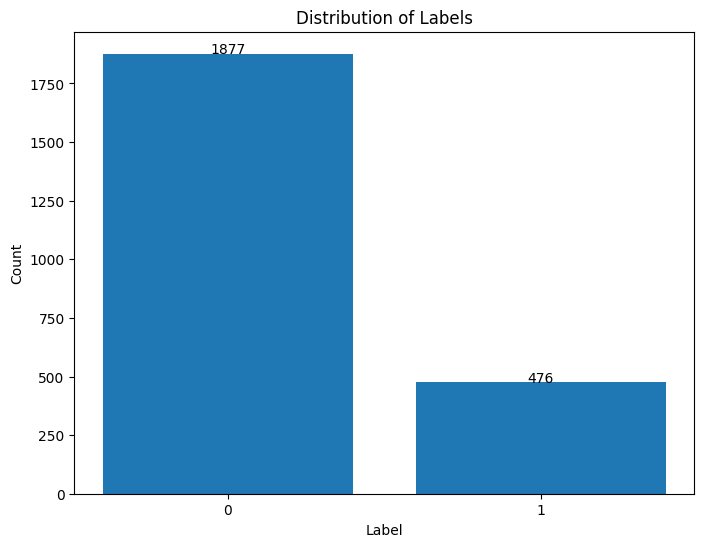

In [8]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [9]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 1882
Number of validation articles: 471


Label 0: 79.28%
Label 1: 20.72%


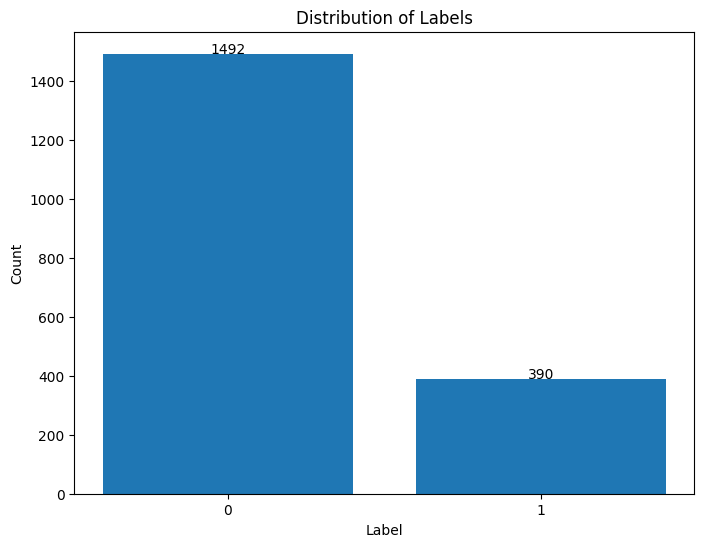

In [10]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

Label 0: 81.74%
Label 1: 18.26%


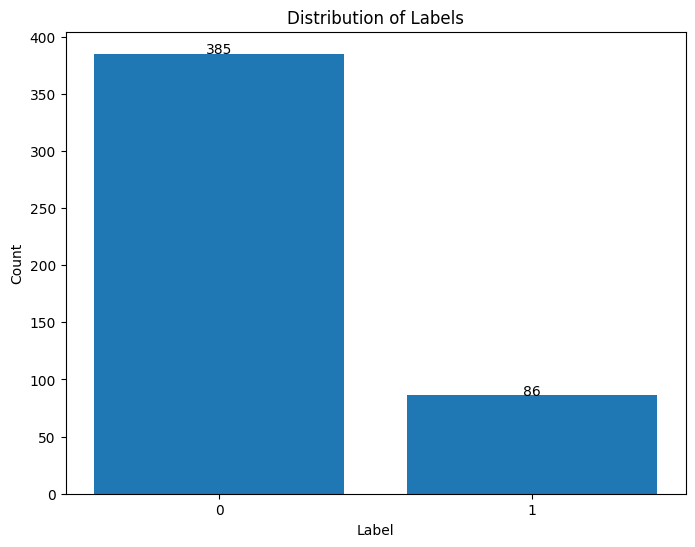

In [11]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [12]:
# 토크나이저 설정

tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다..
Tokenized: ['장학금', '관련해서', '.', '.', '성적', '##장', '##학', '##금', '+', '한울', '##장', '##학', '##금', '가능한', '##지', '궁금합니다', '.', '.']


In [13]:
# 하이퍼파라미터 설정

MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 2e-5

In [14]:
# 텍스트 인코딩

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

/tmp/ipykernel_852347/1232183778.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_852347/1232183778.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_852347/1232183778.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_852347/1232183778.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [15]:
# 학습 전 초기화

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model = AutoModelForSequenceClassification.from_pretrained('beomi/KcELECTRA-base-v2022', num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_accs = []
train_precs = []
train_recs = []
train_f1s = []
train_losses = []

val_accs = []
val_precs = []
val_recs = []
val_f1s = []
val_losses = []

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return acc, prec, rec, f1

In [17]:
# 학습 시작

best_val_f1 = 0.0
best_model_path = None

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f1s.append(train_f1)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_precs.append(val_prec)
    val_recs.append(val_rec)
    val_f1s.append(val_f1)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F1 = {train_f1:.4f}, Train Loss = {train_loss:.4f}')
    print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F1 = {val_f1:.4f}, Val Loss = {val_loss:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_path = f'model-{epoch + 1}-{best_val_f1:.4f}'
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f'  Best model saved with {best_val_f1:.4f} F1 score.')

print('Training finished.')

Epoch 1 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


Epoch 1:
  Train Acc = 0.7991, Train Prec = 0.5857, Train Rec = 0.1051, Train F1 = 0.1783, Train Loss = 0.4632
  Val Acc = 0.9002, Val Prec = 0.8679, Val Rec = 0.5349, Val F1 = 0.6619, Val Loss = 0.2596
  Best model saved with 0.6619 F1 score.


Epoch 2 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Epoch 2:
  Train Acc = 0.9272, Train Prec = 0.8447, Train Rec = 0.7949, Train F1 = 0.8190, Train Loss = 0.2030
  Val Acc = 0.9363, Val Prec = 0.9000, Val Rec = 0.7326, Val F1 = 0.8077, Val Loss = 0.2004
  Best model saved with 0.8077 F1 score.


Epoch 3 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


Epoch 3:
  Train Acc = 0.9718, Train Prec = 0.9399, Train Rec = 0.9231, Train F1 = 0.9314, Train Loss = 0.1010
  Val Acc = 0.9257, Val Prec = 0.7383, Val Rec = 0.9186, Val F1 = 0.8187, Val Loss = 0.2222
  Best model saved with 0.8187 F1 score.


Epoch 4 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


Epoch 4:
  Train Acc = 0.9846, Train Prec = 0.9616, Train Rec = 0.9641, Train F1 = 0.9629, Train Loss = 0.0564
  Val Acc = 0.9406, Val Prec = 0.8222, Val Rec = 0.8605, Val F1 = 0.8409, Val Loss = 0.1977
  Best model saved with 0.8409 F1 score.


Epoch 5 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


Epoch 5:
  Train Acc = 0.9888, Train Prec = 0.9767, Train Rec = 0.9692, Train F1 = 0.9730, Train Loss = 0.0409
  Val Acc = 0.9406, Val Prec = 0.8372, Val Rec = 0.8372, Val F1 = 0.8372, Val Loss = 0.1968


Epoch 6 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Epoch 6:
  Train Acc = 0.9904, Train Prec = 0.9794, Train Rec = 0.9744, Train F1 = 0.9769, Train Loss = 0.0406
  Val Acc = 0.9490, Val Prec = 0.8605, Val Rec = 0.8605, Val F1 = 0.8605, Val Loss = 0.2185
  Best model saved with 0.8605 F1 score.


Epoch 7 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Epoch 7:
  Train Acc = 0.9936, Train Prec = 0.9871, Train Rec = 0.9821, Train F1 = 0.9846, Train Loss = 0.0249
  Val Acc = 0.9172, Val Prec = 0.7196, Val Rec = 0.8953, Val F1 = 0.7979, Val Loss = 0.3282


Epoch 8 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Epoch 8:
  Train Acc = 0.9915, Train Prec = 0.9770, Train Rec = 0.9821, Train F1 = 0.9795, Train Loss = 0.0327
  Val Acc = 0.9448, Val Prec = 0.8571, Val Rec = 0.8372, Val F1 = 0.8471, Val Loss = 0.2210


Epoch 9 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Epoch 9:
  Train Acc = 0.9979, Train Prec = 0.9974, Train Rec = 0.9923, Train F1 = 0.9949, Train Loss = 0.0129
  Val Acc = 0.9172, Val Prec = 0.7080, Val Rec = 0.9302, Val F1 = 0.8040, Val Loss = 0.3781


Epoch 10 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


Epoch 10:
  Train Acc = 0.9963, Train Prec = 0.9898, Train Rec = 0.9923, Train F1 = 0.9910, Train Loss = 0.0093
  Val Acc = 0.9512, Val Prec = 0.8706, Val Rec = 0.8605, Val F1 = 0.8655, Val Loss = 0.2671
  Best model saved with 0.8655 F1 score.


Epoch 11 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]


Epoch 11:
  Train Acc = 0.9942, Train Prec = 0.9847, Train Rec = 0.9872, Train F1 = 0.9859, Train Loss = 0.0153
  Val Acc = 0.8960, Val Prec = 0.6457, Val Rec = 0.9535, Val F1 = 0.7700, Val Loss = 0.4479


Epoch 12 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Epoch 12:
  Train Acc = 0.9968, Train Prec = 0.9923, Train Rec = 0.9923, Train F1 = 0.9923, Train Loss = 0.0157
  Val Acc = 0.9469, Val Prec = 0.8588, Val Rec = 0.8488, Val F1 = 0.8538, Val Loss = 0.2472


Epoch 13 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


Epoch 13:
  Train Acc = 0.9957, Train Prec = 0.9923, Train Rec = 0.9872, Train F1 = 0.9897, Train Loss = 0.0181
  Val Acc = 0.9406, Val Prec = 0.8295, Val Rec = 0.8488, Val F1 = 0.8391, Val Loss = 0.2663


Epoch 14 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.77it/s]


Epoch 14:
  Train Acc = 0.9979, Train Prec = 0.9974, Train Rec = 0.9923, Train F1 = 0.9949, Train Loss = 0.0070
  Val Acc = 0.9236, Val Prec = 0.7273, Val Rec = 0.9302, Val F1 = 0.8163, Val Loss = 0.3369


Epoch 15 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 15:
  Train Acc = 0.9979, Train Prec = 0.9949, Train Rec = 0.9949, Train F1 = 0.9949, Train Loss = 0.0053
  Val Acc = 0.9469, Val Prec = 0.8352, Val Rec = 0.8837, Val F1 = 0.8588, Val Loss = 0.2909


Epoch 16 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9448, Val Prec = 0.8409, Val Rec = 0.8605, Val F1 = 0.8506, Val Loss = 0.3083


Epoch 17 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9448, Val Prec = 0.8333, Val Rec = 0.8721, Val F1 = 0.8523, Val Loss = 0.3176


Epoch 18 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Epoch 18:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9469, Val Prec = 0.8352, Val Rec = 0.8837, Val F1 = 0.8588, Val Loss = 0.3271


Epoch 19 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Epoch 19:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9469, Val Prec = 0.8352, Val Rec = 0.8837, Val F1 = 0.8588, Val Loss = 0.3352


Epoch 20 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Epoch 20:
  Train Acc = 0.9995, Train Prec = 0.9974, Train Rec = 1.0000, Train F1 = 0.9987, Train Loss = 0.0012
  Val Acc = 0.9427, Val Prec = 0.8471, Val Rec = 0.8372, Val F1 = 0.8421, Val Loss = 0.3658


Epoch 21 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 21:
  Train Acc = 0.9957, Train Prec = 0.9897, Train Rec = 0.9897, Train F1 = 0.9897, Train Loss = 0.0188
  Val Acc = 0.9321, Val Prec = 0.8462, Val Rec = 0.7674, Val F1 = 0.8049, Val Loss = 0.3658


Epoch 22 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Epoch 22:
  Train Acc = 0.9947, Train Prec = 0.9897, Train Rec = 0.9846, Train F1 = 0.9871, Train Loss = 0.0132
  Val Acc = 0.9214, Val Prec = 0.7426, Val Rec = 0.8721, Val F1 = 0.8021, Val Loss = 0.4044


Epoch 23 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 23:
  Train Acc = 0.9968, Train Prec = 0.9898, Train Rec = 0.9949, Train F1 = 0.9923, Train Loss = 0.0121
  Val Acc = 0.9490, Val Prec = 0.8690, Val Rec = 0.8488, Val F1 = 0.8588, Val Loss = 0.3045


Epoch 24 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 24:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9974, Train F1 = 0.9987, Train Loss = 0.0027
  Val Acc = 0.9469, Val Prec = 0.8506, Val Rec = 0.8605, Val F1 = 0.8555, Val Loss = 0.3383


Epoch 25 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 25:
  Train Acc = 0.9942, Train Prec = 0.9897, Train Rec = 0.9821, Train F1 = 0.9858, Train Loss = 0.0209
  Val Acc = 0.9363, Val Prec = 0.7917, Val Rec = 0.8837, Val F1 = 0.8352, Val Loss = 0.3033


Epoch 26 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 26:
  Train Acc = 0.9989, Train Prec = 1.0000, Train Rec = 0.9949, Train F1 = 0.9974, Train Loss = 0.0031
  Val Acc = 0.9427, Val Prec = 0.8315, Val Rec = 0.8605, Val F1 = 0.8457, Val Loss = 0.3138


Epoch 27 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0013
  Val Acc = 0.9448, Val Prec = 0.8571, Val Rec = 0.8372, Val F1 = 0.8471, Val Loss = 0.3263


Epoch 28 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9363, Val Prec = 0.7745, Val Rec = 0.9186, Val F1 = 0.8404, Val Loss = 0.4045


Epoch 29 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Epoch 29:
  Train Acc = 0.9989, Train Prec = 0.9974, Train Rec = 0.9974, Train F1 = 0.9974, Train Loss = 0.0055
  Val Acc = 0.9406, Val Prec = 0.8021, Val Rec = 0.8953, Val F1 = 0.8462, Val Loss = 0.3670


Epoch 30 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Epoch 30:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9974, Train F1 = 0.9987, Train Loss = 0.0026
  Val Acc = 0.9299, Val Prec = 0.7573, Val Rec = 0.9070, Val F1 = 0.8254, Val Loss = 0.4255


Epoch 31 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 31:
  Train Acc = 0.9979, Train Prec = 0.9974, Train Rec = 0.9923, Train F1 = 0.9949, Train Loss = 0.0110
  Val Acc = 0.9257, Val Prec = 0.7297, Val Rec = 0.9419, Val F1 = 0.8223, Val Loss = 0.5137


Epoch 32 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 32:
  Train Acc = 0.9888, Train Prec = 0.9767, Train Rec = 0.9692, Train F1 = 0.9730, Train Loss = 0.0368
  Val Acc = 0.9321, Val Prec = 0.7500, Val Rec = 0.9419, Val F1 = 0.8351, Val Loss = 0.3602


Epoch 33 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Epoch 33:
  Train Acc = 0.9989, Train Prec = 0.9949, Train Rec = 1.0000, Train F1 = 0.9974, Train Loss = 0.0046
  Val Acc = 0.9427, Val Prec = 0.8105, Val Rec = 0.8953, Val F1 = 0.8508, Val Loss = 0.3238


Epoch 34 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 34:
  Train Acc = 0.9989, Train Prec = 0.9949, Train Rec = 1.0000, Train F1 = 0.9974, Train Loss = 0.0021
  Val Acc = 0.9469, Val Prec = 0.8765, Val Rec = 0.8256, Val F1 = 0.8503, Val Loss = 0.3501


Epoch 35 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9427, Val Prec = 0.8391, Val Rec = 0.8488, Val F1 = 0.8439, Val Loss = 0.3578


Epoch 36 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9427, Val Prec = 0.8391, Val Rec = 0.8488, Val F1 = 0.8439, Val Loss = 0.3670


Epoch 37 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9427, Val Prec = 0.8391, Val Rec = 0.8488, Val F1 = 0.8439, Val Loss = 0.3746


Epoch 38 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9427, Val Prec = 0.8315, Val Rec = 0.8605, Val F1 = 0.8457, Val Loss = 0.3807


Epoch 39 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9448, Val Prec = 0.8261, Val Rec = 0.8837, Val F1 = 0.8539, Val Loss = 0.3848


Epoch 40 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9448, Val Prec = 0.8261, Val Rec = 0.8837, Val F1 = 0.8539, Val Loss = 0.3894


Epoch 41 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Epoch 41:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9448, Val Prec = 0.8261, Val Rec = 0.8837, Val F1 = 0.8539, Val Loss = 0.3942


Epoch 42 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 42:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9427, Val Prec = 0.8315, Val Rec = 0.8605, Val F1 = 0.8457, Val Loss = 0.4038


Epoch 43 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Epoch 43:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8409, Val Rec = 0.8605, Val F1 = 0.8506, Val Loss = 0.4109


Epoch 44 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 44:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8409, Val Rec = 0.8605, Val F1 = 0.8506, Val Loss = 0.4148


Epoch 45 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 45:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9406, Val Prec = 0.8222, Val Rec = 0.8605, Val F1 = 0.8409, Val Loss = 0.4227


Epoch 46 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 46:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.4282


Epoch 47 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 47:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.4324


Epoch 48 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 48:
  Train Acc = 0.9973, Train Prec = 0.9923, Train Rec = 0.9949, Train F1 = 0.9936, Train Loss = 0.0112
  Val Acc = 0.9384, Val Prec = 0.7822, Val Rec = 0.9186, Val F1 = 0.8449, Val Loss = 0.3759


Epoch 49 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 49:
  Train Acc = 0.9984, Train Prec = 0.9974, Train Rec = 0.9949, Train F1 = 0.9961, Train Loss = 0.0074
  Val Acc = 0.9384, Val Prec = 0.8000, Val Rec = 0.8837, Val F1 = 0.8398, Val Loss = 0.3537


Epoch 50 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 50:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0006
  Val Acc = 0.9448, Val Prec = 0.8261, Val Rec = 0.8837, Val F1 = 0.8539, Val Loss = 0.3747


Epoch 51 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 51:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9406, Val Prec = 0.8085, Val Rec = 0.8837, Val F1 = 0.8444, Val Loss = 0.4073


Epoch 52 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 52:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.4150


Epoch 53 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 53:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.4217


Epoch 54 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 54:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.4296


Epoch 55 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 55:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9427, Val Prec = 0.8041, Val Rec = 0.9070, Val F1 = 0.8525, Val Loss = 0.4456


Epoch 56 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 56:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8041, Val Rec = 0.9070, Val F1 = 0.8525, Val Loss = 0.4520


Epoch 57 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


Epoch 57:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8125, Val Rec = 0.9070, Val F1 = 0.8571, Val Loss = 0.4536


Epoch 58 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 58:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8105, Val Rec = 0.8953, Val F1 = 0.8508, Val Loss = 0.4559


Epoch 59 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 59:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8105, Val Rec = 0.8953, Val F1 = 0.8508, Val Loss = 0.4589


Epoch 60 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 60:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8191, Val Rec = 0.8953, Val F1 = 0.8556, Val Loss = 0.4614


Epoch 61 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 61:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8191, Val Rec = 0.8953, Val F1 = 0.8556, Val Loss = 0.4649


Epoch 62 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 62:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8191, Val Rec = 0.8953, Val F1 = 0.8556, Val Loss = 0.4678


Epoch 63 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 63:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.4710


Epoch 64 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 64:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8041, Val Rec = 0.9070, Val F1 = 0.8525, Val Loss = 0.4864


Epoch 65 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 65:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9427, Val Prec = 0.8041, Val Rec = 0.9070, Val F1 = 0.8525, Val Loss = 0.4868


Epoch 66 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 66:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9448, Val Prec = 0.8125, Val Rec = 0.9070, Val F1 = 0.8571, Val Loss = 0.4875


Epoch 67 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 67:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9448, Val Prec = 0.8125, Val Rec = 0.9070, Val F1 = 0.8571, Val Loss = 0.4898


Epoch 68 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 68:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9448, Val Prec = 0.8125, Val Rec = 0.9070, Val F1 = 0.8571, Val Loss = 0.4919


Epoch 69 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 69:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9448, Val Prec = 0.8125, Val Rec = 0.9070, Val F1 = 0.8571, Val Loss = 0.4938


Epoch 70 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 70:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5032


Epoch 71 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 71:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5057


Epoch 72 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 72:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5086


Epoch 73 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 73:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5110


Epoch 74 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 74:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5148


Epoch 75 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 75:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5170


Epoch 76 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 76:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5194


Epoch 77 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 77:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5216


Epoch 78 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 78:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5342


Epoch 79 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 79:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0003
  Val Acc = 0.9427, Val Prec = 0.8172, Val Rec = 0.8837, Val F1 = 0.8492, Val Loss = 0.5303


Epoch 80 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Epoch 80:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9363, Val Prec = 0.8111, Val Rec = 0.8488, Val F1 = 0.8295, Val Loss = 0.5517


Epoch 81 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Epoch 81:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9363, Val Prec = 0.8111, Val Rec = 0.8488, Val F1 = 0.8295, Val Loss = 0.5557


Epoch 82 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 82:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9363, Val Prec = 0.8111, Val Rec = 0.8488, Val F1 = 0.8295, Val Loss = 0.5582


Epoch 83 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


Epoch 83:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9363, Val Prec = 0.8182, Val Rec = 0.8372, Val F1 = 0.8276, Val Loss = 0.5708


Epoch 84 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 84:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9299, Val Prec = 0.7677, Val Rec = 0.8837, Val F1 = 0.8216, Val Loss = 0.6259


Epoch 85 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Epoch 85:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9299, Val Prec = 0.7677, Val Rec = 0.8837, Val F1 = 0.8216, Val Loss = 0.6283


Epoch 86 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 86:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9321, Val Prec = 0.7755, Val Rec = 0.8837, Val F1 = 0.8261, Val Loss = 0.6261


Epoch 87 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 87:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9342, Val Prec = 0.7835, Val Rec = 0.8837, Val F1 = 0.8306, Val Loss = 0.6277


Epoch 88 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 88:
  Train Acc = 0.9878, Train Prec = 0.9669, Train Rec = 0.9744, Train F1 = 0.9706, Train Loss = 0.0492
  Val Acc = 0.9406, Val Prec = 0.7900, Val Rec = 0.9186, Val F1 = 0.8495, Val Loss = 0.2928


Epoch 89 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 89:
  Train Acc = 0.9968, Train Prec = 0.9948, Train Rec = 0.9897, Train F1 = 0.9923, Train Loss = 0.0113
  Val Acc = 0.9278, Val Prec = 0.7500, Val Rec = 0.9070, Val F1 = 0.8211, Val Loss = 0.3096


Epoch 90 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 90:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9236, Val Prec = 0.7404, Val Rec = 0.8953, Val F1 = 0.8105, Val Loss = 0.4245


Epoch 91 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 91:
  Train Acc = 0.9995, Train Prec = 0.9974, Train Rec = 1.0000, Train F1 = 0.9987, Train Loss = 0.0031
  Val Acc = 0.9427, Val Prec = 0.8105, Val Rec = 0.8953, Val F1 = 0.8508, Val Loss = 0.3842


Epoch 92 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Epoch 92:
  Train Acc = 0.9984, Train Prec = 0.9974, Train Rec = 0.9949, Train F1 = 0.9961, Train Loss = 0.0050
  Val Acc = 0.9172, Val Prec = 0.7156, Val Rec = 0.9070, Val F1 = 0.8000, Val Loss = 0.4384


Epoch 93 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 93:
  Train Acc = 0.9995, Train Prec = 1.0000, Train Rec = 0.9974, Train F1 = 0.9987, Train Loss = 0.0006
  Val Acc = 0.9151, Val Prec = 0.7054, Val Rec = 0.9186, Val F1 = 0.7980, Val Loss = 0.5483


Epoch 94 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 94:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9321, Val Prec = 0.7755, Val Rec = 0.8837, Val F1 = 0.8261, Val Loss = 0.4854


Epoch 95 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Epoch 95:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9321, Val Prec = 0.7755, Val Rec = 0.8837, Val F1 = 0.8261, Val Loss = 0.4895


Epoch 96 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 96:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9342, Val Prec = 0.7835, Val Rec = 0.8837, Val F1 = 0.8306, Val Loss = 0.4895


Epoch 97 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 97:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0004
  Val Acc = 0.9384, Val Prec = 0.8000, Val Rec = 0.8837, Val F1 = 0.8398, Val Loss = 0.4755


Epoch 98 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Epoch 98:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9384, Val Prec = 0.8000, Val Rec = 0.8837, Val F1 = 0.8398, Val Loss = 0.4999


Epoch 99 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Epoch 99:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9384, Val Prec = 0.8000, Val Rec = 0.8837, Val F1 = 0.8398, Val Loss = 0.5068


Epoch 100 - Validation: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]

Epoch 100:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0000
  Val Acc = 0.9384, Val Prec = 0.8000, Val Rec = 0.8837, Val F1 = 0.8398, Val Loss = 0.5133
Training finished.


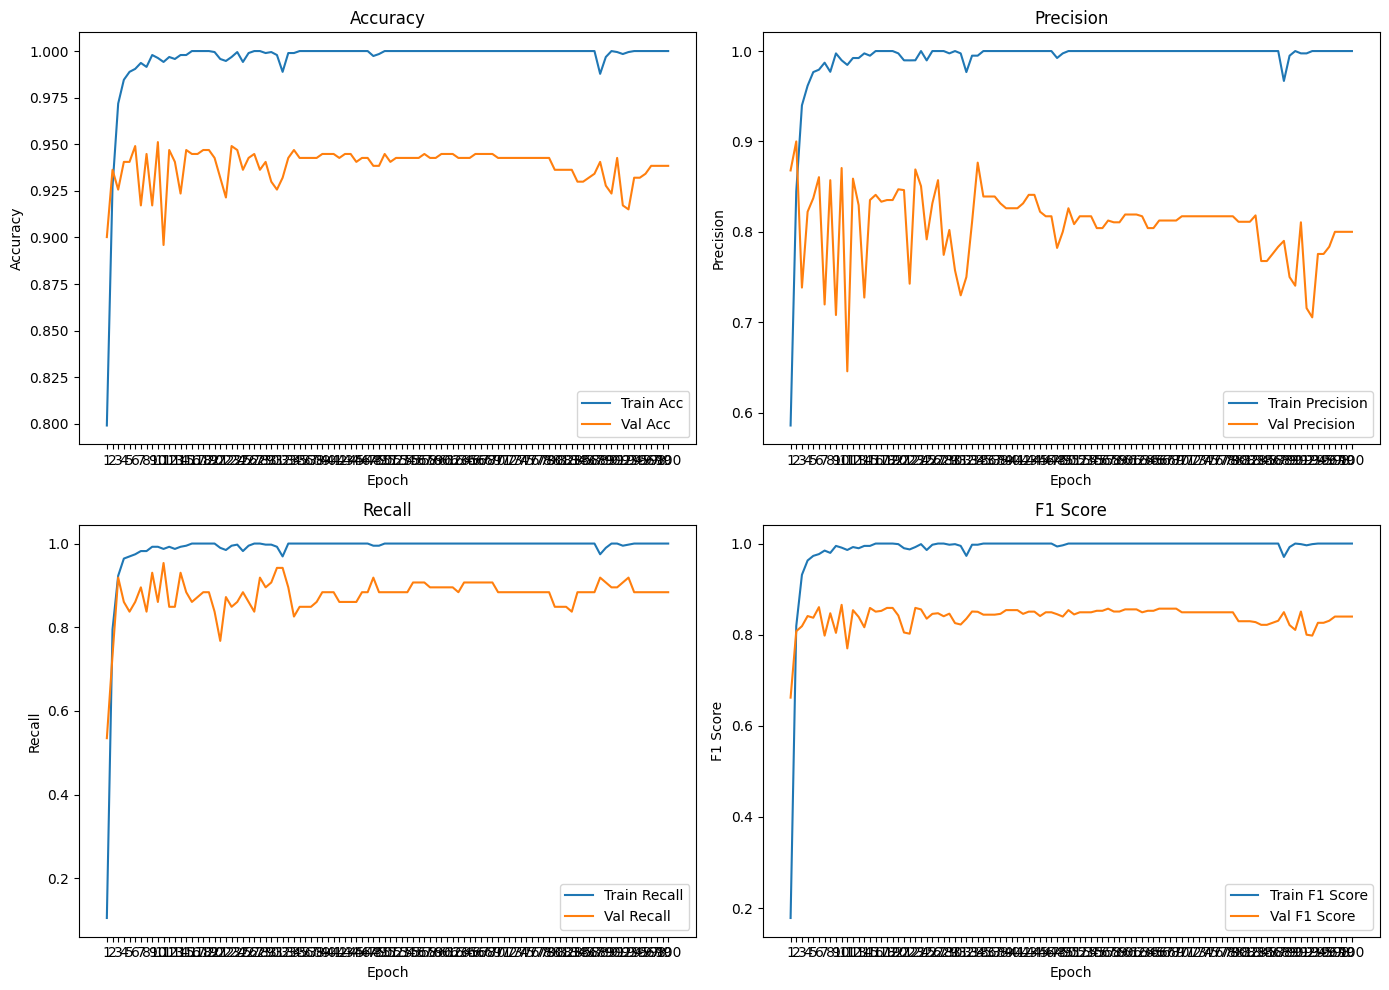

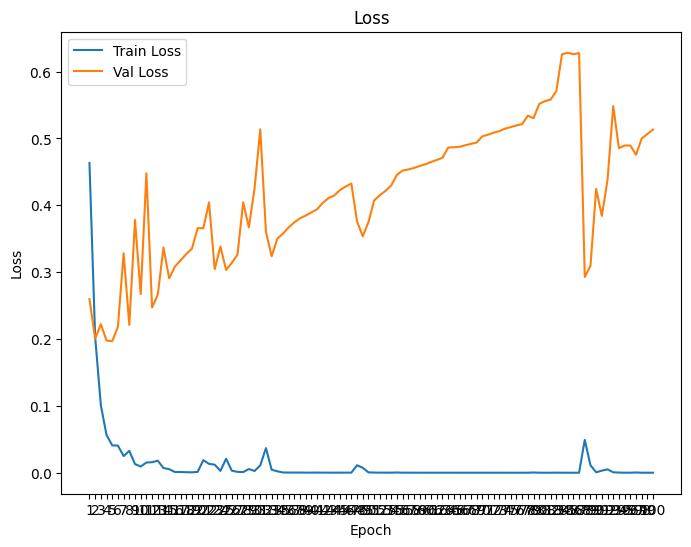

In [18]:
# 학습 결과 시각화

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(train_precs, label='Train Precision')
plt.plot(val_precs, label='Val Precision')
plt.xlabel('Epoch')
plt.xticks(range(len(train_precs)), range(1, len(train_precs) + 1))
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.plot(train_recs, label='Train Recall')
plt.plot(val_recs, label='Val Recall')
plt.xlabel('Epoch')
plt.xticks(range(len(train_recs)), range(1, len(train_recs) + 1))
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(val_f1s, label='Val F1 Score')
plt.xlabel('Epoch')
plt.xticks(range(len(train_f1s)), range(1, len(train_f1s) + 1))
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [19]:
# 평가

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=2)
model.to(device)

predictions = [
    '이번 학기 선형대수학 수업 너무 어려워요. 교수님 강의 스타일이 적응이 안 됩니다.',
    '자바 프로그래밍 과제 제출 기한이 언제까지인가요?',
    '데이터베이스 설계 프로젝트 팀원 구합니다. 같이 하실 분 연락 주세요.',
    '기계학습 수업에서 배우는 알고리즘들이 흥미롭네요. 실제 활용 사례도 알고 싶어요.',
    '오퍼레이션스 리서치 수업 듣는 사람 있나요? 같이 공부해요.',
    '축제 때 학교에서 벚꽃 구경하는 것도 좋더라.',
    '맛있는 점심 식사 했어요. 오늘 메뉴가 좋았어요.',
    'intramural soccer 동아리 활동이 재미있어요. 다음 경기가 기대됩니다.',
    '도서관에서 공부하다가 커피 마시러 갔어요.',
    '날씨가 좋아서 친구들이랑 한강 공원에서 운동했어요.',
    '장학금 받았는데 성적장학금인거 증명할 수 있는 증명서? 뽑을 수 있나요?'
]

encodings = tokenizer(
    predictions,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1).tolist()

for text, label, probs in zip(predictions, predicted_labels, probabilities.tolist()):
    sentiment = '수업/이과' if label == 1 else '그 외'
    print(f'텍스트: {text}')
    print(f'예측: {sentiment} {probs}')
    print()

텍스트: 이번 학기 선형대수학 수업 너무 어려워요. 교수님 강의 스타일이 적응이 안 됩니다.
예측: 수업/이과 [0.0020770500414073467, 0.997922956943512]

텍스트: 자바 프로그래밍 과제 제출 기한이 언제까지인가요?
예측: 수업/이과 [0.0020984646398574114, 0.9979015588760376]

텍스트: 데이터베이스 설계 프로젝트 팀원 구합니다. 같이 하실 분 연락 주세요.
예측: 수업/이과 [0.002248830161988735, 0.9977511763572693]

텍스트: 기계학습 수업에서 배우는 알고리즘들이 흥미롭네요. 실제 활용 사례도 알고 싶어요.
예측: 수업/이과 [0.0021366244181990623, 0.9978633522987366]

텍스트: 오퍼레이션스 리서치 수업 듣는 사람 있나요? 같이 공부해요.
예측: 수업/이과 [0.0028402789030224085, 0.9971597194671631]

텍스트: 축제 때 학교에서 벚꽃 구경하는 것도 좋더라.
예측: 그 외 [0.999421238899231, 0.0005788368871435523]

텍스트: 맛있는 점심 식사 했어요. 오늘 메뉴가 좋았어요.
예측: 그 외 [0.9994117021560669, 0.000588282651733607]

텍스트: intramural soccer 동아리 활동이 재미있어요. 다음 경기가 기대됩니다.
예측: 수업/이과 [0.13972139358520508, 0.8602786660194397]

텍스트: 도서관에서 공부하다가 커피 마시러 갔어요.
예측: 그 외 [0.9993516802787781, 0.0006483028410002589]

텍스트: 날씨가 좋아서 친구들이랑 한강 공원에서 운동했어요.
예측: 그 외 [0.9993460774421692, 0.0006539611495099962]

텍스트: 장학금 받았는데 성적장학금인거 증명할 수 있는 증명서? 뽑을 수 있나요?
예측: 그 외 [0.99938404